<h1 align="center">All relevant feature selection</h1>
<h2 align="center"> Regression - Leshy (Boruta evolution), BoostAGroota (BoostARoota evolution), GrootCV (new) </h2>
<p style="text-align:center">
   Human Bender<br>
</p>

<div align="center">
    <img border="0" src="bender_hex_mini.png" width="100px" align="center" />
</div>




<h2 style="color:#deab02;">1 - Configuration, Loading the packages, data and utilities definition </h2>
 

First let's set the libraries, general settings and define some functions (in the notebook for convenience, will be moved in a library during a later stage).

## Packages

In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))

from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_openml
from sklearn.inspection import permutation_importance
import catboost
from catboost import CatBoostRegressor, CatBoostClassifier
from boruta import BorutaPy as bp
from sklearn.datasets import load_boston, load_diabetes, load_breast_cancer
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import gc
import shap
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sys import getsizeof, path
import arfs
import arfs.featselect as arfsfs
import arfs.allrelevant as arfsgroot
from arfs.utils import LightForestClassifier, LightForestRegressor
from arfs.utils import highlight_tick, compare_varimp
from arfs.utils import load_data, sklearn_pimp_bench
plt.style.use('fivethirtyeight')
rng = np.random.RandomState(seed=42)

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
gc.enable()
gc.collect()

45

<h2 style="color:#deab02;"> Simple Usage </h2>
In the following examples, I'll use a classical data set to which I added random predictors (numerical and categorical). An All Relveant FS methods should discard them.
In the unit tests, you'll find examples using artifical data with genuine (correlated and non-linear) predictors and with some random/noise columns.

## Leshy (Boruta evolution)

In [4]:
boston = load_data(name='Boston')
X, y = boston.data, boston.target

In [5]:
X.dtypes

CRIM           float64
ZN             float64
INDUS          float64
CHAS            object
NOX            float64
RM             float64
AGE            float64
DIS            float64
RAD             object
TAX            float64
PTRATIO        float64
B              float64
LSTAT          float64
random_num1    float64
random_num2      int32
random_cat      object
genuine_num    float64
dtype: object

In [6]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,random_num1,random_num2,random_cat,genuine_num
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,0.496714,1,7,6.073864
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,-0.138264,2,6,5.914890
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,0.647689,1,8,6.841044
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,1.523030,0,6,6.440272
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,-0.234153,0,2,6.610492


In [7]:
# Let's use lightgbm as booster, see below for using more models
model = LGBMRegressor(random_state=42, verbose=-1)

Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:01<00:00,  4.61it/s]




Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	7
Tentative: 	0
Rejected: 	7
All relevant predictors selected in 00:00:01.96
['NOX', 'RM', 'DIS', 'TAX', 'PTRATIO', 'LSTAT', 'genuine_num']


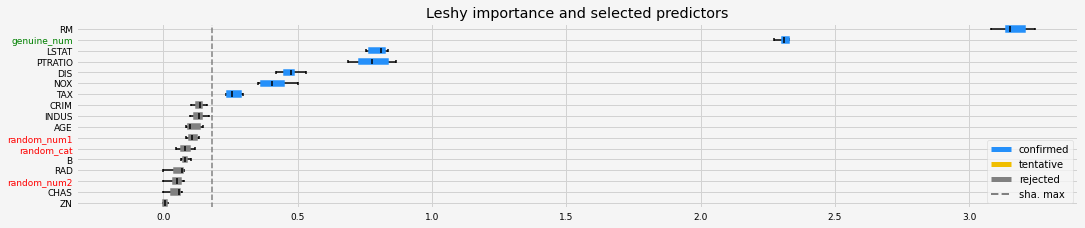

Wall time: 2.3 s


In [8]:
%%time
# Leshy
feat_selector = arfsgroot.Leshy(model, n_estimators = 100, verbose= 1, max_iter= 10, random_state=42, importance='shap')
feat_selector.fit(X, y, sample_weight=None)
print(feat_selector.support_names_)
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random and genuine variables
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()

In [9]:
feat_selector.tag_df

,predictor,Boruta,Boruta_weak_incl
0,CRIM,0,0
1,ZN,0,0
2,INDUS,0,0
3,CHAS,0,0
4,NOX,1,1
5,RM,1,1
6,AGE,0,0
7,DIS,1,1
8,RAD,0,0
9,TAX,1,1


## BoostAGroota

BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:02<00:21,  2.38s/it]

0           CRIM
1            NOX
2             RM
3            DIS
4        PTRATIO
5          LSTAT
6    genuine_num
Name: feature, dtype: object


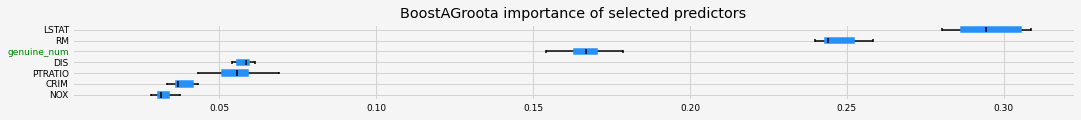

Wall time: 2.56 s


In [10]:
%%time
# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(est=model, cutoff=1, iters=10, max_rounds=10, delta=0.1, importance='shap')
feat_selector.fit(X, y, sample_weight=None)
print(feat_selector.support_names_)
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random and genuine variables
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')

plt.show()

## GrootCV

Repeated k-fold: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:07<00:00,  3.27it/s]


0             AGE
2            CRIM
3             DIS
5           LSTAT
6             NOX
7         PTRATIO
8              RM
9             TAX
11    genuine_num
Name: feature, dtype: object


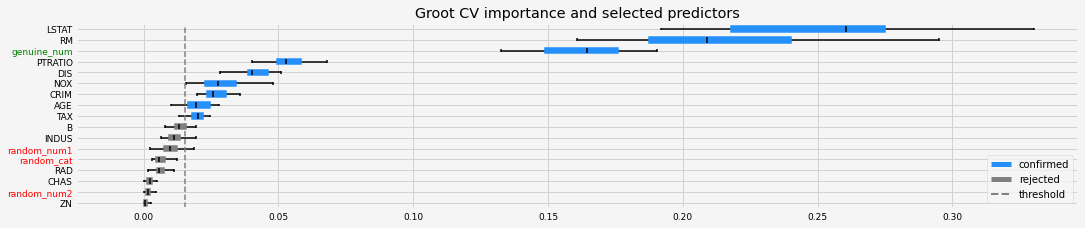

Wall time: 8.01 s


In [11]:
%%time
# GrootCV
feat_selector = arfsgroot.GrootCV(objective='rmse', cutoff = 1, n_folds=5, n_iter=5)
feat_selector.fit(X, y, sample_weight=None)
print(feat_selector.support_names_)
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random and genuine variables
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')

plt.show()

<h2 style="color:#deab02;"> Testing and comparing Leshy, GrootCV and BoostAGroota </h2>

In the following examples, I'll use different models which are scikit-learn compatible and then one can compare the different ARFS methods with different models and the different feature importance.

==================== Benchmarking using sklearn permutation importance ====================


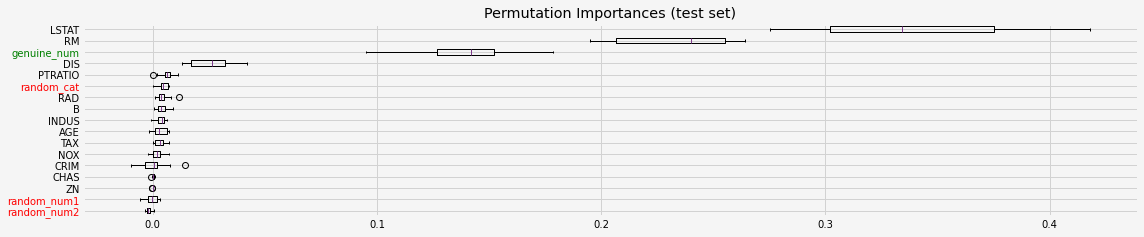

Wall time: 2.88 s


In [12]:
%%time

# Benchmark with scikit-learn permutation importance
print('=' * 20 + ' Benchmarking using sklearn permutation importance ' + '=' * 20)
fig = sklearn_pimp_bench(model, X, y, task='regression', sample_weight=None)

# Testing Leshy

Leshy iteration:   0%|                                                                                                                                                | 0/10 [00:00<?, ?it/s]

==================== Leshy - testing:         RandomForestRegressor(n_jobs=4, oob_score=True) for var.imp: shap            ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:01<00:00,  4.54it/s]




Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	7
Tentative: 	2
Rejected: 	5
All relevant predictors selected in 00:00:01.99
['NOX', 'RM', 'DIS', 'TAX', 'PTRATIO', 'LSTAT', 'genuine_num']


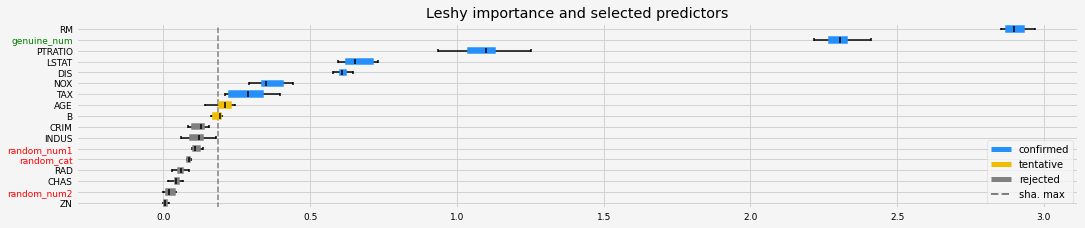

Leshy iteration:   0%|                                                                                                                                                | 0/10 [00:00<?, ?it/s]

==================== Leshy - testing:         RandomForestRegressor(n_jobs=4, oob_score=True) for var.imp: pimp            ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:06<00:00,  1.34it/s]




Leshy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	7
Tentative: 	4
Rejected: 	2
All relevant predictors selected in 00:00:06.75
['NOX', 'RM', 'DIS', 'PTRATIO', 'B', 'LSTAT', 'genuine_num']


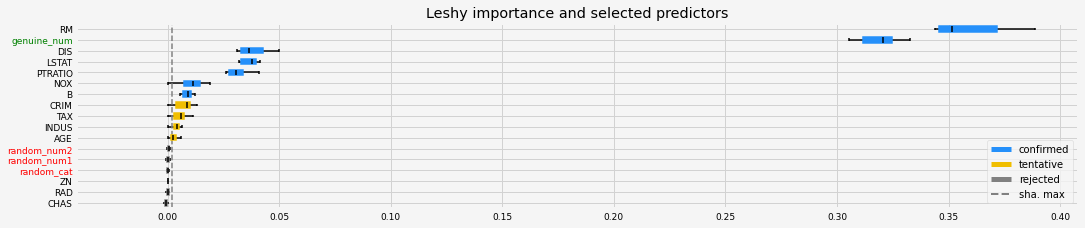

Leshy iteration:  10%|█████████████▌                                                                                                                          | 1/10 [00:00<00:00,  9.12it/s]

==================== Leshy - testing:         RandomForestRegressor(n_jobs=4, oob_score=True) for var.imp: native          ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:01<00:00,  7.70it/s]




Leshy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	5
Tentative: 	4
Rejected: 	6
All relevant predictors selected in 00:00:01.18
['RM', 'AGE', 'DIS', 'LSTAT', 'genuine_num']


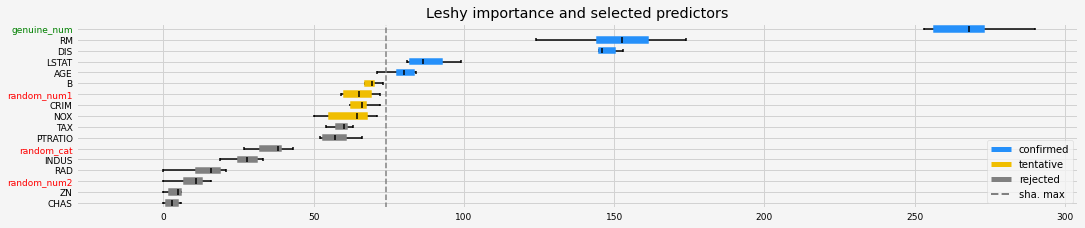

Leshy iteration:  10%|█████████████▌                                                                                                                          | 1/10 [00:00<00:01,  5.54it/s]

==================== Leshy - testing: <catboost.core.CatBoostRegressor object at 0x0000028A179A2148> for var.imp: shap            ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:01<00:00,  5.06it/s]




Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	7
Tentative: 	3
Rejected: 	4
All relevant predictors selected in 00:00:01.79
['NOX', 'RM', 'DIS', 'TAX', 'PTRATIO', 'LSTAT', 'genuine_num']


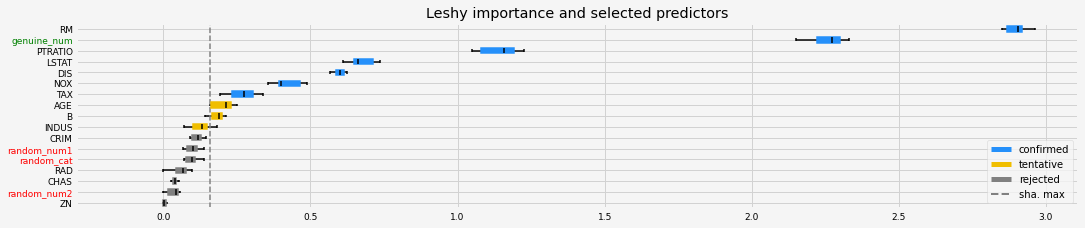

Leshy iteration:   0%|                                                                                                                                                | 0/10 [00:00<?, ?it/s]

==================== Leshy - testing: <catboost.core.CatBoostRegressor object at 0x0000028A179A2148> for var.imp: pimp            ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:03<00:00,  2.37it/s]




Leshy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	9
Tentative: 	2
Rejected: 	5
All relevant predictors selected in 00:00:03.80
['INDUS', 'NOX', 'RM', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'genuine_num']


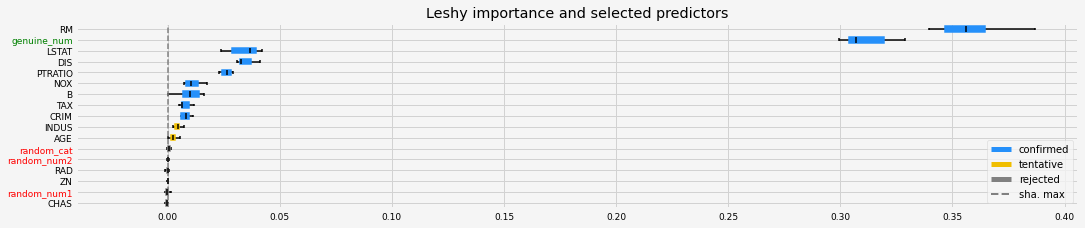

Leshy iteration:  10%|█████████████▌                                                                                                                          | 1/10 [00:00<00:00,  9.12it/s]

==================== Leshy - testing: <catboost.core.CatBoostRegressor object at 0x0000028A179A2148> for var.imp: native          ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:01<00:00,  7.77it/s]




Leshy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	6
Tentative: 	3
Rejected: 	6
All relevant predictors selected in 00:00:01.17
['CRIM', 'RM', 'AGE', 'DIS', 'LSTAT', 'genuine_num']


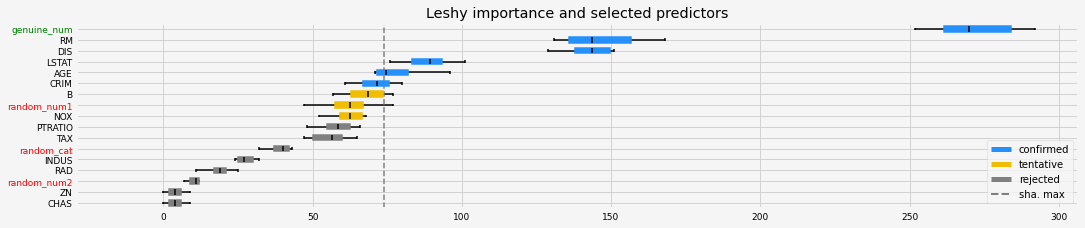

Leshy iteration:  10%|█████████████▌                                                                                                                          | 1/10 [00:00<00:01,  5.66it/s]

==================== Leshy - testing: XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=0) for var.imp: shap            ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:01<00:00,  5.13it/s]




Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	7
Tentative: 	2
Rejected: 	5
All relevant predictors selected in 00:00:01.77
['NOX', 'RM', 'DIS', 'TAX', 'PTRATIO', 'LSTAT', 'genuine_num']


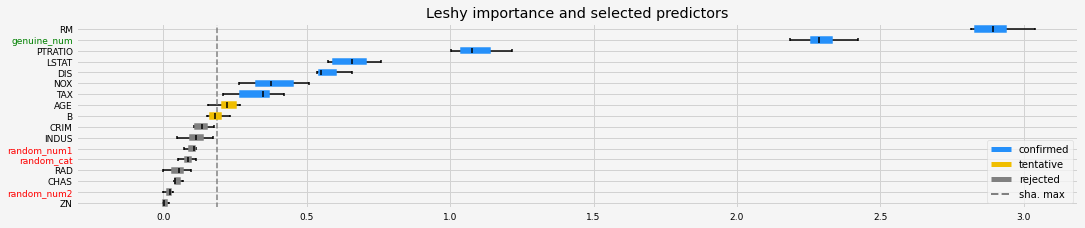

Leshy iteration:   0%|                                                                                                                                                | 0/10 [00:00<?, ?it/s]

==================== Leshy - testing: XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=0) for var.imp: pimp            ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:03<00:00,  2.43it/s]




Leshy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	11
Tentative: 	0
Rejected: 	5
All relevant predictors selected in 00:00:03.72
['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'genuine_num']


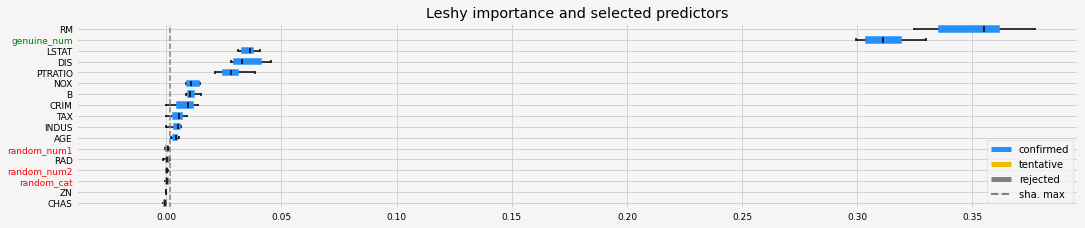

Leshy iteration:  10%|█████████████▌                                                                                                                          | 1/10 [00:00<00:01,  8.87it/s]

==================== Leshy - testing: XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=0) for var.imp: native          ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:01<00:00,  7.70it/s]




Leshy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	5
Tentative: 	5
Rejected: 	6
All relevant predictors selected in 00:00:01.18
['CRIM', 'RM', 'DIS', 'LSTAT', 'genuine_num']


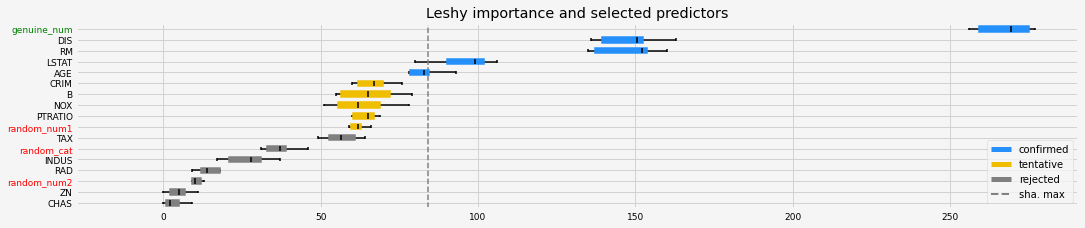

Leshy iteration:  10%|█████████████▌                                                                                                                          | 1/10 [00:00<00:01,  5.22it/s]

==================== Leshy - testing:              LGBMRegressor(random_state=42, verbose=-1) for var.imp: shap            ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:01<00:00,  5.09it/s]




Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	7
Tentative: 	2
Rejected: 	6
All relevant predictors selected in 00:00:01.78
['NOX', 'RM', 'DIS', 'TAX', 'PTRATIO', 'LSTAT', 'genuine_num']


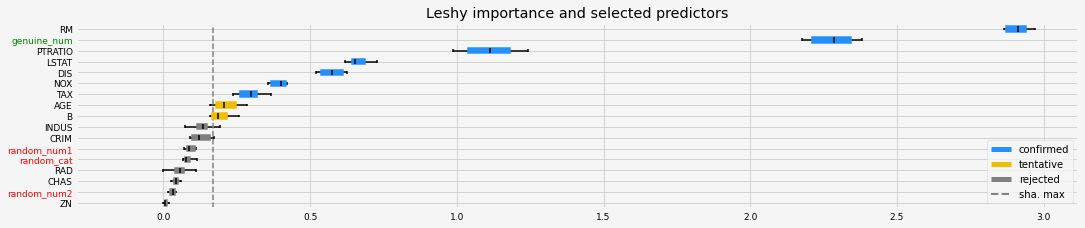

Leshy iteration:   0%|                                                                                                                                                | 0/10 [00:00<?, ?it/s]

==================== Leshy - testing:              LGBMRegressor(random_state=42, verbose=-1) for var.imp: pimp            ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:03<00:00,  2.35it/s]




Leshy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	9
Tentative: 	2
Rejected: 	3
All relevant predictors selected in 00:00:03.84
['CRIM', 'NOX', 'RM', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'genuine_num']


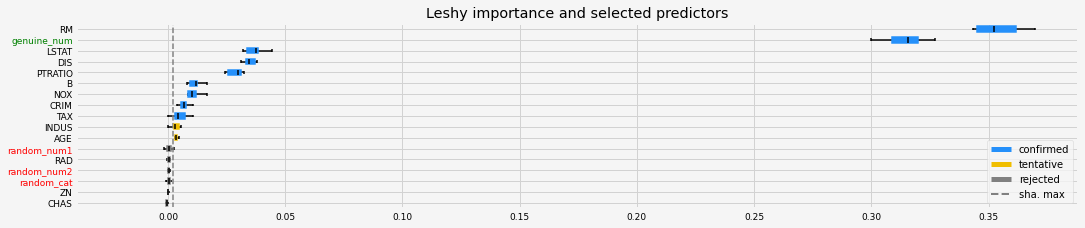

Leshy iteration:  10%|█████████████▌                                                                                                                          | 1/10 [00:00<00:00,  9.12it/s]

==================== Leshy - testing:              LGBMRegressor(random_state=42, verbose=-1) for var.imp: native          ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:01<00:00,  7.71it/s]




Leshy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	5
Tentative: 	5
Rejected: 	6
All relevant predictors selected in 00:00:01.18
['RM', 'AGE', 'DIS', 'LSTAT', 'genuine_num']


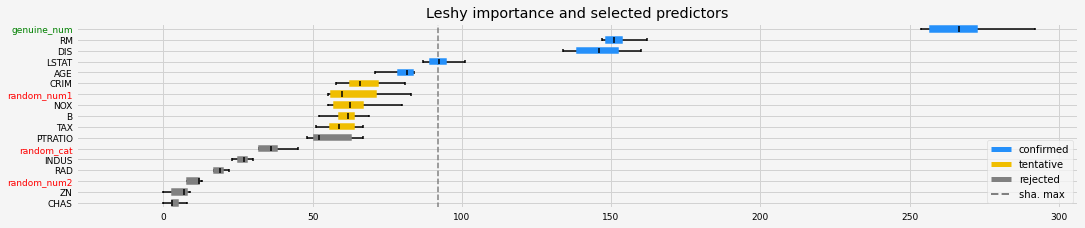

Leshy iteration:   0%|                                                                                                                                                | 0/10 [00:00<?, ?it/s]

==================== Leshy - testing: LGBMRegressor(boosting_type='rf', colsample_bytree=0.3333333333333333,
              force_col_wise=True, subsample=0.632, subsample_freq=1,
              verbose=-1) for var.imp: shap            ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:01<00:00,  4.96it/s]




Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	9
Tentative: 	1
Rejected: 	5
All relevant predictors selected in 00:00:01.82
['NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'genuine_num']


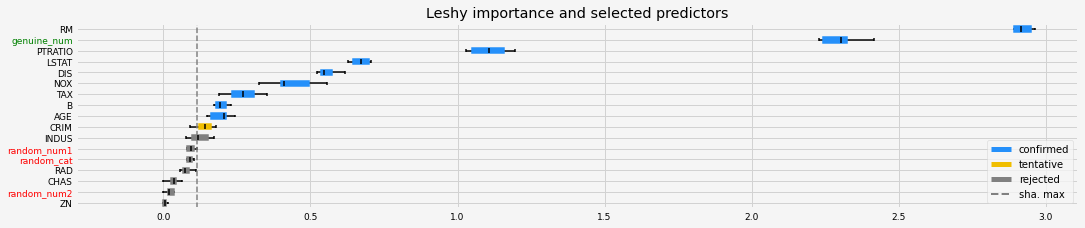

Leshy iteration:   0%|                                                                                                                                                | 0/10 [00:00<?, ?it/s]

==================== Leshy - testing: LGBMRegressor(boosting_type='rf', colsample_bytree=0.3333333333333333,
              force_col_wise=True, subsample=0.632, subsample_freq=1,
              verbose=-1) for var.imp: pimp            ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:04<00:00,  2.19it/s]




Leshy finished running using pimp var. imp.

Iteration: 	10 / 10
Confirmed: 	9
Tentative: 	2
Rejected: 	3
All relevant predictors selected in 00:00:04.12
['CRIM', 'INDUS', 'NOX', 'RM', 'DIS', 'PTRATIO', 'B', 'LSTAT', 'genuine_num']


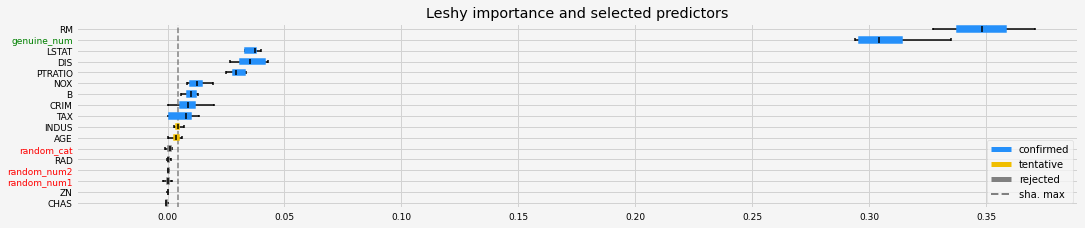

Leshy iteration:  10%|█████████████▌                                                                                                                          | 1/10 [00:00<00:01,  7.37it/s]

==================== Leshy - testing: LGBMRegressor(boosting_type='rf', colsample_bytree=0.3333333333333333,
              force_col_wise=True, subsample=0.632, subsample_freq=1,
              verbose=-1) for var.imp: native          ====================


Leshy iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:01<00:00,  7.46it/s]




Leshy finished running using native var. imp.

Iteration: 	10 / 10
Confirmed: 	4
Tentative: 	3
Rejected: 	6
All relevant predictors selected in 00:00:01.22
['RM', 'DIS', 'LSTAT', 'genuine_num']


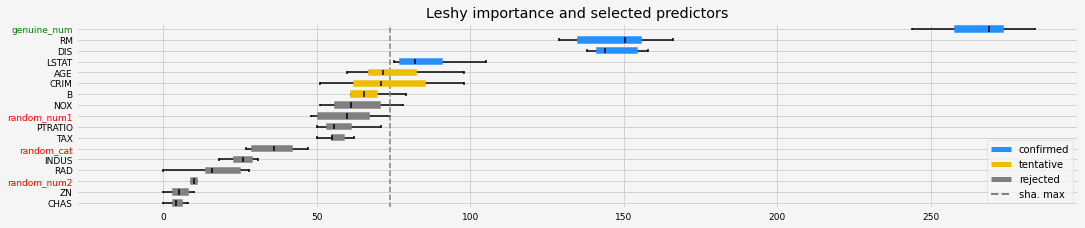

In [13]:
models = [RandomForestRegressor(n_jobs= 4, oob_score= True), 
          CatBoostRegressor(random_state=42, verbose=0), 
          XGBRegressor(random_state=42, verbosity=0), 
          LGBMRegressor(random_state=42, verbose=-1),
          LightForestRegressor(n_feat=X.shape[1])]

feat_selector = arfsgroot.Leshy(model, n_estimators = 100, verbose= 1, max_iter= 10, random_state=42)

if __name__ == '__main__':
    # regression
    boston = load_data(name='Boston')
    X, y = boston.data, boston.target
    # running the ARFS methods using different models
    compare_varimp(feat_selector, models, X, y, sample_weight=None)

# Testing GrootCV

Repeated k-fold: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:05<00:00,  4.34it/s]


0             AGE
1               B
2            CRIM
3             DIS
5           LSTAT
6             NOX
7         PTRATIO
8              RM
11    genuine_num
Name: feature, dtype: object


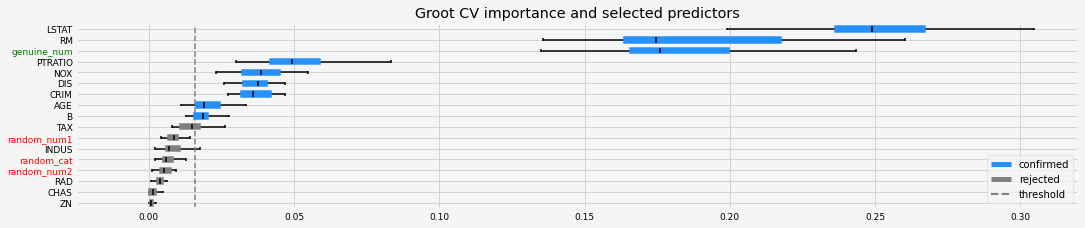

In [16]:
# Testing the changes with rnd cat. and num. predictors added to the set of genuine predictors
def testing_estimators(X, y, sample_weight=None, objective='rmse'):
    feat_selector = arfsgroot.GrootCV(objective=objective, cutoff = 1, n_folds=5, n_iter=5)
    feat_selector.fit(X, y, sample_weight)
    print(feat_selector.support_names_)
    fig = feat_selector.plot_importance(n_feat_per_inch=5)

    # highlight synthetic random variable
    fig = highlight_tick(figure=fig, str_match='random')
    fig = highlight_tick(figure=fig, str_match='genuine', color='green')
    plt.show()
    gc.enable()
    del(feat_selector)
    gc.collect()
        

if __name__ == '__main__':
    # regression
    boston = load_data(name='Boston')
    X, y = boston.data, boston.target
    cat_f = boston.categorical
    testing_estimators(X=X, y=y, objective='rmse')

# Testing BoostAGroota

BoostaGRoota round:   0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]

==================== BoostAGroota - testing:        RandomForestClassifier(n_jobs=4, oob_score=True) for var.imp: shap            ====================


BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:02<00:21,  2.37s/it]

0           CRIM
1             RM
2            AGE
3            DIS
4            TAX
5        PTRATIO
6          LSTAT
7    genuine_num
Name: feature, dtype: object


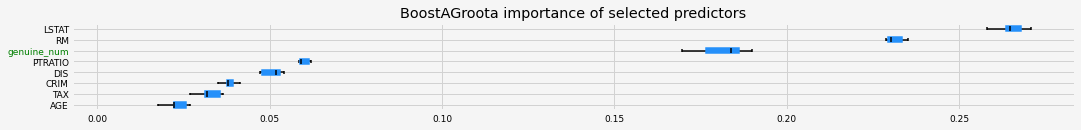

BoostaGRoota round:   0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]

==================== BoostAGroota - testing:        RandomForestClassifier(n_jobs=4, oob_score=True) for var.imp: pimp            ====================


BoostaGRoota round:  20%|██████████████████████████▌                                                                                                          | 2/10 [00:09<00:38,  4.86s/it]

0           CRIM
1            NOX
2             RM
3            DIS
4            TAX
5        PTRATIO
6          LSTAT
7    genuine_num
Name: feature, dtype: object


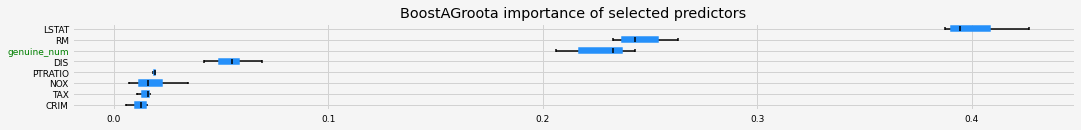

BoostaGRoota round:   0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]

==================== BoostAGroota - testing:        RandomForestClassifier(n_jobs=4, oob_score=True) for var.imp: native          ====================


BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:01<00:10,  1.13s/it]

0           CRIM
1             RM
2            DIS
3          LSTAT
4    genuine_num
Name: feature, dtype: object


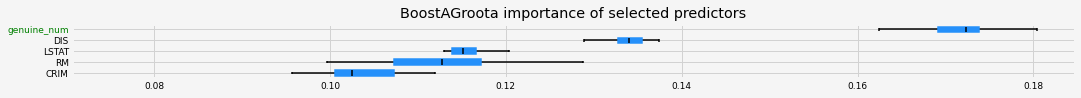

BoostaGRoota round:   0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]

==================== BoostAGroota - testing: <catboost.core.CatBoostClassifier object at 0x0000028A16087948> for var.imp: shap            ====================


BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:02<00:22,  2.45s/it]


0           CRIM
1            NOX
2             RM
3            AGE
4            DIS
5            TAX
6        PTRATIO
7          LSTAT
8    genuine_num
Name: feature, dtype: object


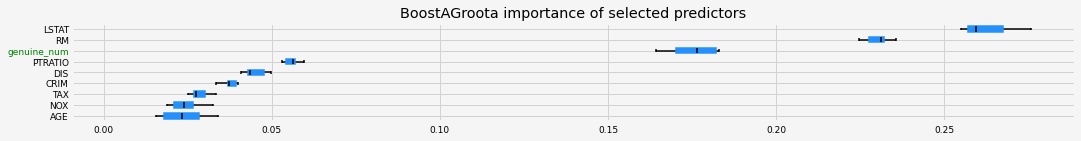

BoostaGRoota round:   0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]

==================== BoostAGroota - testing: <catboost.core.CatBoostClassifier object at 0x0000028A16087948> for var.imp: pimp            ====================


BoostaGRoota round:  20%|██████████████████████████▌                                                                                                          | 2/10 [00:08<00:35,  4.43s/it]

0           CRIM
1            NOX
2             RM
3            DIS
4            TAX
5        PTRATIO
6          LSTAT
7    genuine_num
Name: feature, dtype: object


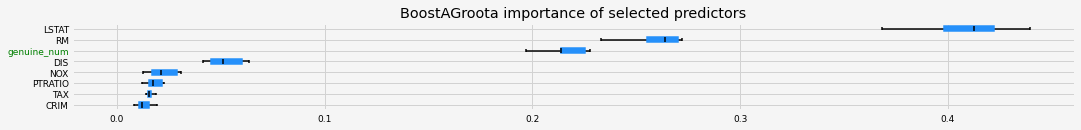

BoostaGRoota round:   0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]

==================== BoostAGroota - testing: <catboost.core.CatBoostClassifier object at 0x0000028A16087948> for var.imp: native          ====================


BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:01<00:09,  1.02s/it]

0           CRIM
1             RM
2            DIS
3          LSTAT
4    genuine_num
Name: feature, dtype: object


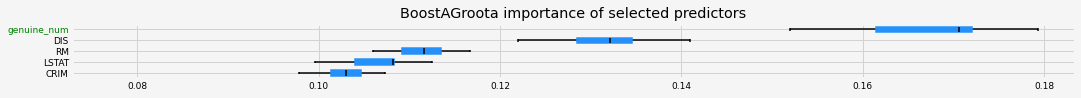

BoostaGRoota round:   0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]

==================== BoostAGroota - testing: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=0) for var.imp: shap            ====================


BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:02<00:20,  2.29s/it]

0           CRIM
1            NOX
2             RM
3            AGE
4            DIS
5            TAX
6        PTRATIO
7          LSTAT
8    genuine_num
Name: feature, dtype: object


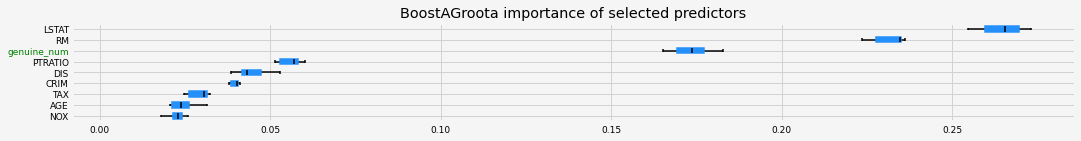

BoostaGRoota round:   0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]

==================== BoostAGroota - testing: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=0) for var.imp: pimp            ====================


BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:06<00:59,  6.57s/it]

0           CRIM
1            NOX
2             RM
3            DIS
4            TAX
5        PTRATIO
6              B
7          LSTAT
8    genuine_num
Name: feature, dtype: object


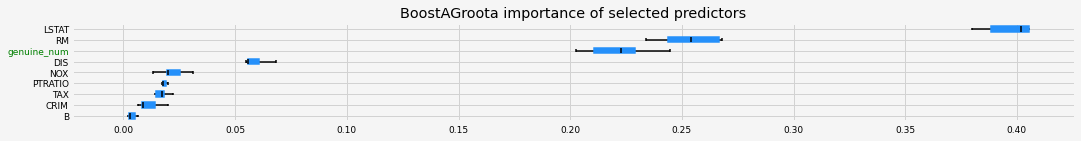

==================== BoostAGroota - testing: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=0) for var.imp: native          ====================


BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:01<00:10,  1.15s/it]

0           CRIM
1             RM
2            DIS
3          LSTAT
4    genuine_num
Name: feature, dtype: object


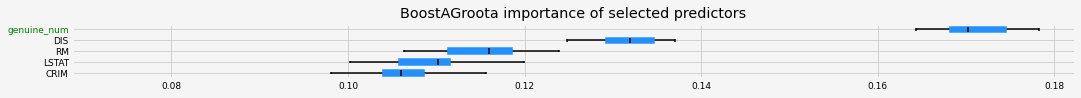

BoostaGRoota round:   0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]

==================== BoostAGroota - testing:             LGBMClassifier(random_state=42, verbose=-1) for var.imp: shap            ====================


BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:02<00:21,  2.39s/it]

0           CRIM
1            NOX
2             RM
3            AGE
4            DIS
5            TAX
6        PTRATIO
7          LSTAT
8    genuine_num
Name: feature, dtype: object


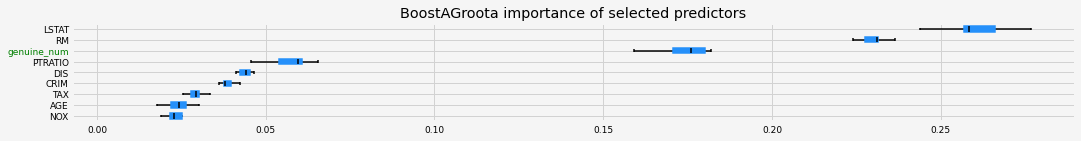

BoostaGRoota round:   0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]

==================== BoostAGroota - testing:             LGBMClassifier(random_state=42, verbose=-1) for var.imp: pimp            ====================


BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:07<01:03,  7.08s/it]

0           CRIM
1            NOX
2             RM
3            DIS
4            TAX
5        PTRATIO
6          LSTAT
7    genuine_num
Name: feature, dtype: object


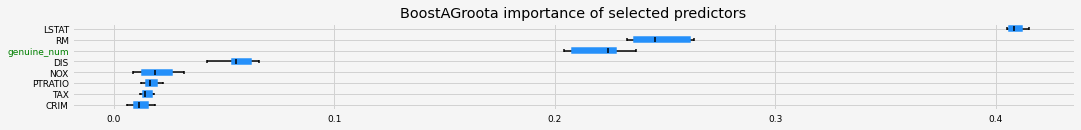

==================== BoostAGroota - testing:             LGBMClassifier(random_state=42, verbose=-1) for var.imp: native          ====================


BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:01<00:10,  1.13s/it]

0           CRIM
1             RM
2            DIS
3          LSTAT
4    genuine_num
Name: feature, dtype: object


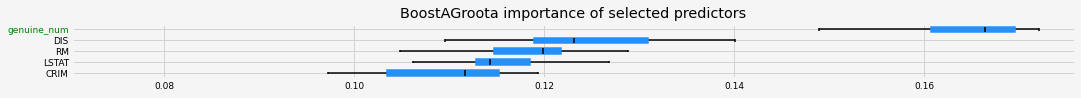

BoostaGRoota round:   0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]

==================== BoostAGroota - testing: LGBMClassifier(boosting_type='rf', colsample_bytree=0.24253562503633297,
               force_col_wise=True, subsample=0.632, subsample_freq=1,
               verbose=-1) for var.imp: shap            ====================


BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:02<00:21,  2.42s/it]

0           CRIM
1             RM
2            DIS
3            TAX
4        PTRATIO
5          LSTAT
6    genuine_num
Name: feature, dtype: object


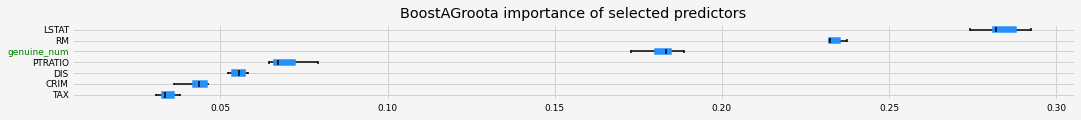

==================== BoostAGroota - testing: LGBMClassifier(boosting_type='rf', colsample_bytree=0.24253562503633297,
               force_col_wise=True, subsample=0.632, subsample_freq=1,
               verbose=-1) for var.imp: pimp            ====================


BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:06<01:01,  6.80s/it]

0           CRIM
1            NOX
2             RM
3            DIS
4            TAX
5        PTRATIO
6          LSTAT
7    genuine_num
Name: feature, dtype: object


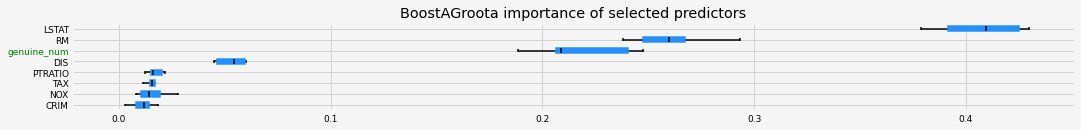

BoostaGRoota round:   0%|                                                                                                                                             | 0/10 [00:00<?, ?it/s]

==================== BoostAGroota - testing: LGBMClassifier(boosting_type='rf', colsample_bytree=0.24253562503633297,
               force_col_wise=True, subsample=0.632, subsample_freq=1,
               verbose=-1) for var.imp: native          ====================


BoostaGRoota round:  10%|█████████████▎                                                                                                                       | 1/10 [00:00<00:08,  1.00it/s]

0           CRIM
1             RM
2            DIS
3          LSTAT
4    genuine_num
Name: feature, dtype: object


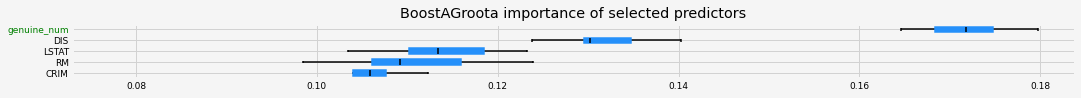

In [15]:
models = [RandomForestClassifier(n_jobs= 4, oob_score= True), 
          CatBoostClassifier(random_state=42, verbose=0), 
          XGBClassifier(random_state=42, verbosity=0), 
          LGBMClassifier(random_state=42, verbose=-1),
          LightForestClassifier(n_feat=X.shape[1])]

feat_selector = arfsgroot.BoostAGroota(est=model, cutoff=1, iters=10, max_rounds=10, delta=0.1)

if __name__ == '__main__':
    # regression
    boston = load_data(name='Boston')
    X, y = boston.data, boston.target
    cat_f = boston.categorical
    # running the ARFS methods using different models
    compare_varimp(feat_selector, models, X, y, sample_weight=None)